In [11]:
import pandas as pd
import os
import ast
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from openai import OpenAI
from langchain.prompts import PromptTemplate
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from gensim import models, corpora
import pyLDAvis.gensim
import unidecode

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [12]:
os.environ['OPENAI_API_KEY'] = os.environ.get('OPENAI_API_KEY')

In [13]:
prompt_template = PromptTemplate.from_template(
    '''
    Your task is to extract keywords from {sentence}.
    You are an assistant for labeling negative annotaded keywords in user reviews.
    Return the words that are assumed to be negative words in form of a list.
    Note: If now negative words detected reutrn empty list.
    Note: Words have to stand alone as negative to be included. No fill words.
    Note: Only words that are explicit in the sentence should be included.
    Provide output without further text information. Use the following schema ['keyword 1', 'keyword 2', ...]
    '''
)


In [14]:
client = OpenAI()

In [16]:
def extract_keywords(sentence: str) -> str:
    try:
        # Format the prompt dynamically with the input sentence
        prompt = prompt_template.format(sentence=sentence)
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error: {e}"

#### prepare keyword strings

In [17]:
def remove_stopwords(text: str, sw = stopwords.words('german')) -> str:
    '''
    This function will remove stopwords from the text
    
    Args:
        text: String of data you want to remove stopwords from
        sw: List of strings indicating the list of stopwords
        
    Returns:
        The input string with the stopwords removed.
    '''
    additional_sw = ['not','dont','no', 'longer', 'quiet', 'peace', 'unfortunately', 'avoid']
    sw = sw + additional_sw
    
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return ' '.join(text_list)

In [18]:
def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
    '''
    This function will remove punctuations from the text.
    
    Args:
        text: String of data you want to remove punctuations from
        punct: String of punctuations
    
    Returns:
        The input string with the punctuations removed.
    '''
    cleaned_text = ''.join([char for char in text if char not in punct])
    return cleaned_text

In [19]:
def unicode(text: str) -> str:
    '''
    This function will make all the data unicoded. Meaning Â -> A
    
    Args:
        text: String of data you want to unicode
    
    Returns:
        The input string unicoded.
    '''
    return unidecode.unidecode(text)

In [20]:
def clean(text: str) -> str:
    '''
    This method will clean the input text through unidecoding and stopword and punctuation 
    removal.
    
    Args:
        text: String indicating the body of text you want to clean
    
    Returns:
        A string corresponding to the cleaned version of the input string.
    '''
    text = unicode(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text.lower()

In [ ]:
df = pd.read_csv('../data/processed/review_data_berlin.csv')

#### keyword analysis

In [24]:
def transform_list (keywords):
    try:
        keyword_list = ast.literal_eval(keywords)
        return keyword_list
    except Exception as e:
        return f"Error: {e}"

In [25]:
df['keywords_list'] = df['keywords'].apply(lambda x: transform_list(x))

In [47]:
df.head(4)

,Unnamed: 0,google_id,review_text,review_img_urls,review_rating,review_timestamp,review_likes,review_text_english,clean_reviews,keywords,keywords_list
0,0,0x47a84f4c8819b367:0xedafc45032d4521b,I happened to visit the park around midday on ...,['https://lh5.googleusercontent.com/p/AF1QipNH...,1,1730831520,5,I happened to visit the park around midday on ...,i happened to visit the park around midday on ...,"['tipsy', 'drugs', 'homeless', 'rubbish']","[tipsy, drugs, homeless, rubbish]"
1,1,0x47a84f4c8819b367:0xedafc45032d4521b,"The park is nice, it surprised me that there w...",['https://lh5.googleusercontent.com/p/AF1QipNs...,5,1723813004,0,"The park is nice, it surprised me that there w...",the park is nice it surprised me that there a ...,[],[]
2,2,0x47a84f4c8819b367:0xedafc45032d4521b,Legenday park in Berlin! Somehow between Kreuz...,['https://lh5.googleusercontent.com/p/AF1QipNA...,5,1724322017,0,Legenday park in Berlin! Somehow between Kreuz...,legenday park berlin somehow between kreuzberg...,[],[]
3,3,0x47a84f4c8819b367:0xedafc45032d4521b,I have to be honest and didn't feel particular...,NaN,4,1733680520,0,I have to be honest and didn't feel particular...,i have to be honest and didnt feel particularl...,"['unsafe', 'dealers', 'nicked']","[unsafe, dealers, nicked]"


In [35]:
df.keywords_list[0][2]

'homeless'

In [38]:
flattened_keywords = [keyword for sublist in df['keywords_list'] for keyword in sublist]

In [39]:
cleaned_keywords = [word for word in flattened_keywords if len(word.strip()) > 1]

In [53]:
c = Counter(cleaned_keywords).most_common(10)
c

[('n', 62),
 (' ', 55),
 ('r', 33),
 ('i', 32),
 ('l', 22),
 ('dealers', 21),
 ('drug', 21),
 ('a', 21),
 ('o', 20),
 ('e', 17)]

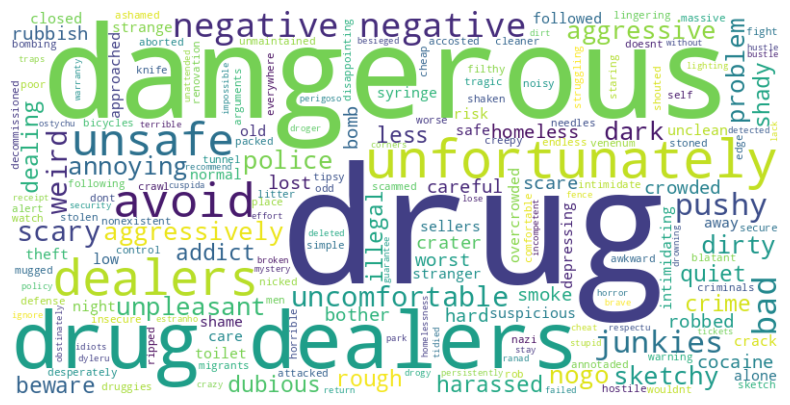

In [203]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(cleaned_keywords))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### topic clustering

In [54]:
# kill single letters

In [55]:
def kill_letters (keywords):
    survivors = [word for word in keywords if len(word.strip()) > 1]
    return survivors

In [58]:
df['keywords_clean'] = df['keywords_list'].apply(lambda x: kill_letters(x))

In [59]:
df_c = df.copy()

In [61]:
df_c.reset_index(drop=True, inplace=True)

In [115]:
df_c.head(3)

,Unnamed: 0,google_id,review_text,review_img_urls,review_rating,review_timestamp,review_likes,review_text_english,clean_reviews,keywords,keywords_list,keywords_clean,keywords_string
0,0,0x47a84f4c8819b367:0xedafc45032d4521b,I happened to visit the park around midday on ...,['https://lh5.googleusercontent.com/p/AF1QipNH...,1,1730831520,5,I happened to visit the park around midday on ...,i happened to visit the park around midday on ...,"['tipsy', 'drugs', 'homeless', 'rubbish']","[tipsy, drugs, homeless, rubbish]","[tipsy, drugs, homeless, rubbish]",tipsy drugs homeless rubbish
1,1,0x47a84f4c8819b367:0xedafc45032d4521b,"The park is nice, it surprised me that there w...",['https://lh5.googleusercontent.com/p/AF1QipNs...,5,1723813004,0,"The park is nice, it surprised me that there w...",the park is nice it surprised me that there a ...,[],[],[],
2,2,0x47a84f4c8819b367:0xedafc45032d4521b,Legenday park in Berlin! Somehow between Kreuz...,['https://lh5.googleusercontent.com/p/AF1QipNA...,5,1724322017,0,Legenday park in Berlin! Somehow between Kreuz...,legenday park berlin somehow between kreuzberg...,[],[],[],


In [123]:
df_c = df_c[df_c['keywords_list'].apply(lambda x: len(x)!=0)]

In [124]:
df_c['keywords_clean'].iloc[0]

['tipsy', 'drugs', 'homeless', 'rubbish']

In [155]:
df_c['keywords_clean'] = df_c['keywords_clean'].apply(
    lambda lst: [word.replace('drugs', 'drug') for word in lst] if isinstance(lst, list) else lst
)

/tmp/ipykernel_26418/431072509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['keywords_clean'] = df_c['keywords_clean'].apply(


In [165]:
df_c['keywords_string'] = df_c['keywords_clean'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

/tmp/ipykernel_26418/338318158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['keywords_string'] = df_c['keywords_clean'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')


In [191]:
keyword_summary = df_c['keywords_string'].values

In [192]:
keyword_summary = [[word for word in nltk.word_tokenize(keywords)] for keywords in keyword_summary]

In [193]:
dictionary = corpora.Dictionary(keyword_summary)

In [194]:
corpus = [dictionary.doc2bow(keywords) for keywords in keyword_summary]

In [198]:
lda = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=20)

In [199]:
lda_vis = pyLDAvis.gensim.prepare(
    lda,
    corpus, 
    dictionary=lda.id2word,
    mds='mmds',
    sort_topics=False
)

pyLDAvis.display(lda_vis)

In [200]:
lda

In [202]:
df.to_csv('../data/processed/goerli_test.csv')

#### all parks